# 1. Исследовательский анализ данных

In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
display(labels.head(5))
print('='*40)
display(labels.info())
print('='*40)
display(labels.describe())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


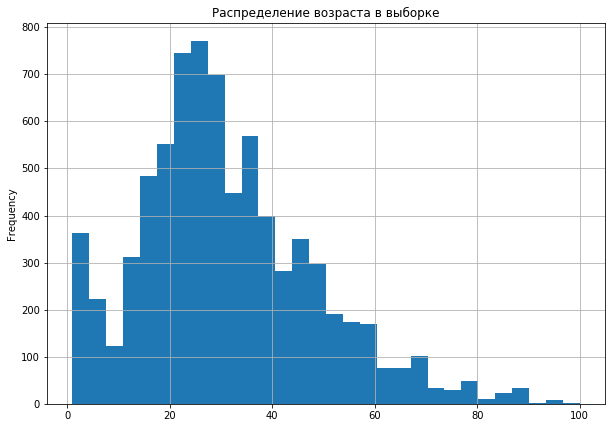

In [4]:
labels['real_age'].plot(kind='hist', bins=30, figsize=(10,7), title='Распределение возраста в выборке', grid=True)

#### Вывод: 
- в исследуемой выборке больше всего представителей возраста 20-30 лет, с увеличением возраста представителей их количество существенно снижается. Так же представленно достаточно большое количество детей. Тем не мнее данные распределены около-нормально.
- выбросы в выборке отсутствуют.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_gen_flow = train_datagen.flow_from_dataframe(
         dataframe=labels,
         directory='/datasets/faces/final_files/',
         x_col='file_name',
         y_col='real_age',
         target_size=(224, 224),
         batch_size=32,
         class_mode='raw',
         seed=42)

Found 7591 validated image filenames.


In [7]:
features, target = next(train_gen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

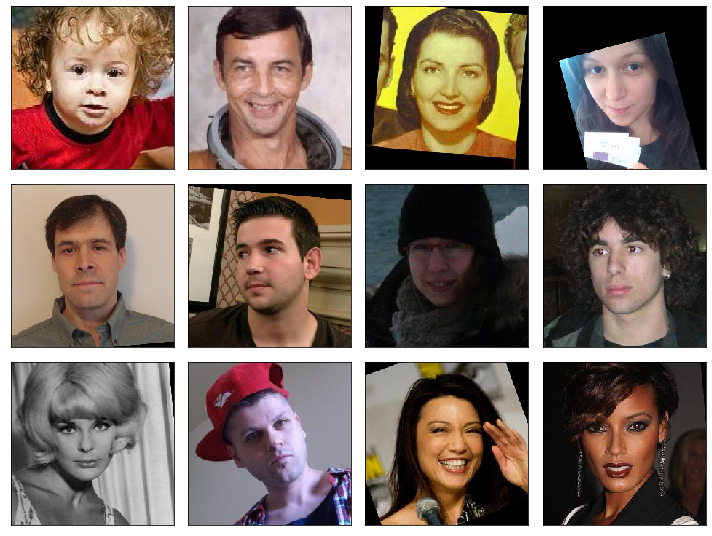

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### Вывод: 
- фотографии представляют собой лица людей, часто встречаются аугументации.
- для решения задачи будет использоваться:  
        сверточная нейронная сеть ResNet;  
        решаться будет задача регрессии с одним выходным нейроном;  
        для активации нейронов будем использовать функцию ReLU;  
        метрикой качества выступит MAE;  
        для подбора learning rate используем алгоритм Adam  
        размерность будем уменьшать методом глобального пулинга.  

# 2. Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

60/60 - 9s - loss: 62.7555 - mae: 5.9165
Test MAE: 5.9165

```

# 3. Анализ обученной модели

#### Вывод:
Целью данной работы являлось создание модели компьютерного зрения для обработки фотографий покупателей для контроля кассиров при продаже алкоголя несовершеннолетним, а так же анализа потребительской карзины по возрастам покупателей. Для этой цели:  
- в качестве модели была выбрана нейросеть, как наиболее подходящий инструмент по анализу изображений. Под задачу распознавания отлично подходит предобученая нейросеть ResNet50, которой мы и воспользовались, дообучив ее под наши данные  
- так как задачей являлось определение возраста покупателя (задача регрессии), то и выходной нейрон всего один - предсказанный возраст  
- в качестве функции активации исользовалась самая популярная (и самая лучшая на данный момент) функция активации ReLu  
- в качестве оптимизатора использовался Adam в виду своей наилучшей оптимизирующей способности  
- для уменьшения колличества параметров для полносвязного выходного слоя использовался GlobalAveragePooling2D  
- мы смогли получить погрешность в 5.92 лет, что считаю очень хорошим результатом. Цель достигнута